<a href="https://colab.research.google.com/github/samuel-haddad/TreeClassifiersReview/blob/main/trees_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn prediction: ensembles models**
**Keywords:** Random Forrest, Extra Trees, binary, classifier, k-fold

## Telco Costumer Churn

This will be a quick exercise in building classification models with the k-fold cross-validation technique. For this reason, we will not look very closely at data exploration and will do a simple treatment of missing values ​​using the IterativeImputer library, a more sophisticated solution for replacing with regression. <br>

<br>**Dabase description:**<br>
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

## **Data understanding**

In [ ]:
%%capture

# setup do environment
!pip install sweetviz

# general libs
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std

In [ ]:
# import the dataset and create the dataframe
df_churn = pd.read_csv('https://raw.githubusercontent.com/samuel-haddad/TreeClassifiersReview/main/WA_Fn-UseC_-Telco-Customer-Churn.csv', delimiter=',')

# falling in love with the dataset
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# eda lib
import sweetviz as sv

# creating EDA report and open the html file
df_eda = sv.analyze(df_churn)
df_eda.show_html('telco-costumer-churn.html') # save as html file to better explore data in a browser tab

                                             |          | [  0%]   00:00 -> (? left)

Report telco-costumer-churn.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## **Data preparation**

In [ ]:
# preparation lib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# copy df
df_prep = df_churn.copy()

df_prep['TotalCharges'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'])

# imp
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_prep[['TotalCharges']])

# transform
df_ii = imp.transform(df_prep[['TotalCharges']])

# replace
df_prep[['TotalCharges']] = df_ii
df_churn_gold = df_prep

In [ ]:
# creating EDA report and open the html file
df_eda_gold = sv.analyze(df_churn_gold)
df_eda_gold.show_html('telco-costumer-churn_gold.html') # save as html file to better explore data in a browser tab

                                             |          | [  0%]   00:00 -> (? left)

Report telco-costumer-churn_gold.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


tenure: 0 outliers
MonthlyCharges: 0 outliers
TotalCharges: 0 outliers


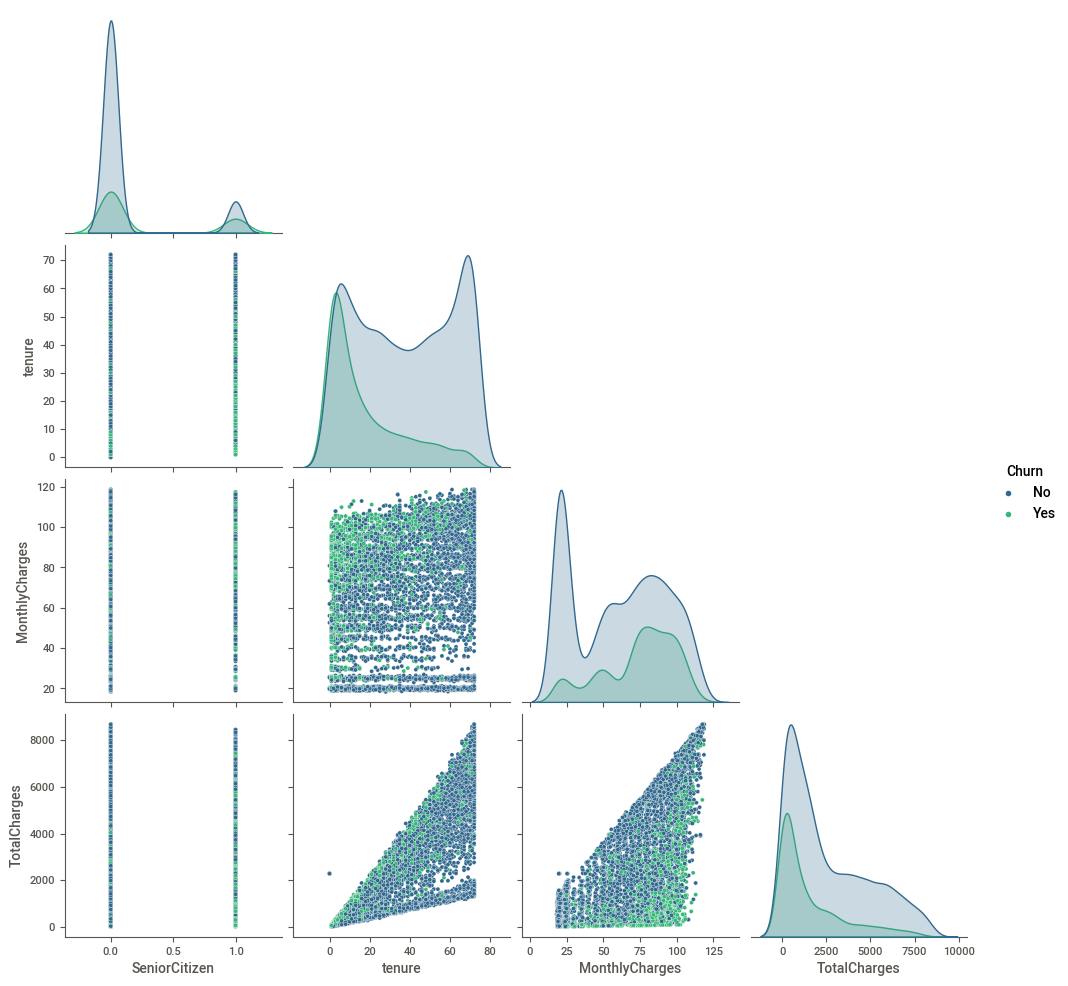

In [ ]:
# outliers count
'''
Credits: Anandmural | https://www.kaggle.com/anandmural/diabetesprediction
'''
for column in df_churn_gold[['tenure','MonthlyCharges', 'TotalCharges']]:
    Q1 = df_churn_gold[column].quantile(0.25)
    Q3 = df_churn_gold[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_range = (df_churn_gold[column] < (Q1 - 1.5*IQR)) | (df_churn_gold[column] > (Q3 + 1.5 * IQR))
    num_outliers = df_churn_gold[column][outlier_range].count()
    print(f"{column}: {num_outliers} outliers")

# use pairplot to show relationships between features and individual distributions
sns.pairplot(data=df_churn_gold, hue="Churn", corner=True, diag_kind="kde", palette="viridis");

In [ ]:
# dummy variables
df_churn_gold['Churn'].replace({'No':0, 'Yes':1}, inplace=True)
df_dummies = pd.get_dummies(df_churn_gold.drop(['customerID','SeniorCitizen', 'tenure','MonthlyCharges', 'TotalCharges', 'Churn'], axis=1))
df = pd.concat([df_dummies, df_churn_gold[['SeniorCitizen', 'tenure','MonthlyCharges', 'TotalCharges', 'Churn']]], axis=1)
df.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,1,0,1,0,0,1,...,1,0,0,1,0,0,1,29.85,29.85,0
1,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,1,0,34,56.95,1889.50,0
2,0,1,1,0,1,0,0,1,1,0,...,1,0,0,0,1,0,2,53.85,108.15,1
3,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,45,42.30,1840.75,0
4,1,0,1,0,1,0,0,1,1,0,...,1,0,0,1,0,0,2,70.70,151.65,1


## **Model: Extra Trees**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# extract the explanatory variables
X, y = df.drop('Churn', axis=1), df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# define the model
clf = ExtraTreesClassifier(random_state=42)

# training the model
clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
print("Train score: ", score)

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

y_pred = clf.predict(X_test)

# compare train & test distribuition
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)

# statistics
print('+',29*'-','MODEL STATISTICS',29*'-','+')
print('Train dist: {}%'.format(round(y_train_dist*100, 2))
        ,'| Test dist: {}%'.format(round(y_test_dist*100, 2)))
print(80*'-')
print("Accuracy: {}%".format((metrics.accuracy_score(y_test, y_pred)*100).round(2))
        ,"| Precision: {}%".format((metrics.precision_score(y_test, y_pred)*100).round(2))
        ,"| Recall: {}%".format((metrics.recall_score(y_test, y_pred)*100).round(2)))
print(80*'-')
print("AUC: {}%".format((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])*100).round(2))
        ,"| F1: {}%".format(((f1_score(y_test, y_pred))*100).round(2))
        ,'| LL: {}'.format(-metrics.log_loss(y_test, clf.predict_proba(X_test), normalize=False)))
print('+',78*'-','+')
print(clf.feature_importances_)


Train score:  0.9983772819472616
Accuracy: 0.762 (0.014)
+ ----------------------------- MODEL STATISTICS ----------------------------- +
Train dist: 26.27% | Test dist: 27.17%
--------------------------------------------------------------------------------
Accuracy: 76.95% | Precision: 59.65% | Recall: 46.86%
--------------------------------------------------------------------------------
AUC: 79.49% | F1: 52.49% | LL: -1610.5491200703673
+ ------------------------------------------------------------------------------ +
[0.02112163 0.02158155 0.01774256 0.01797964 0.01577017 0.01470568
 0.00340482 0.00327403 0.01665023 0.00304301 0.01598644 0.01267184
 0.02324346 0.00329422 0.02772292 0.00207479 0.01508014 0.01817755
 0.00259797 0.01497311 0.0173838  0.00361691 0.01429712 0.02856367
 0.00372707 0.01173725 0.01503943 0.00373692 0.01457152 0.01388122
 0.00239523 0.01514973 0.05601922 0.01401582 0.02383995 0.01572276
 0.01719512 0.01580973 0.01523712 0.0308238  0.01404698 0.02598153
 0.1

### **Validation**

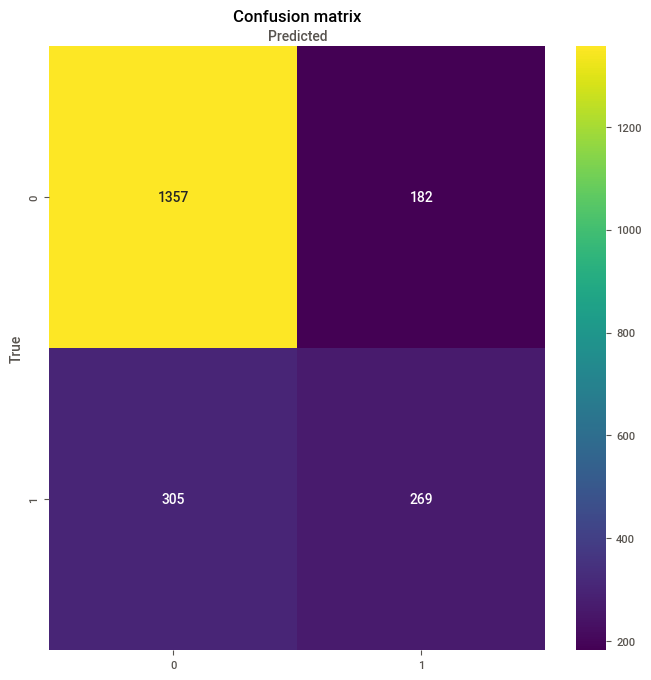

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots(figsize=(8, 8))
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted');

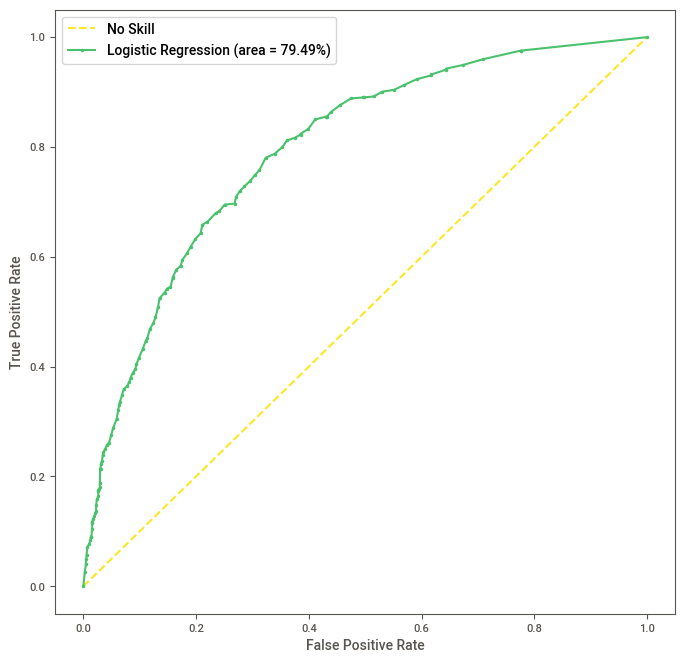

In [ ]:
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax

# Predict test_y values and probabilities based on fitted logistic regression model
yhat = clf.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='Logistic Regression (area = {}%)'.format((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])*100).round(2)))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()

---

## **Model: Random Forrest**

### **Data preparation**

In [ ]:
# preparation lib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#copy df
df_prep = df_churn.copy()

df_prep['TotalCharges'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'])

#df_prep.loc[:, ['TotalCharges']].replace (r'\s+', np.nan, regex = True, inplace = True)

#imp
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_prep[['TotalCharges']])

#transform
df_ii = imp.transform(df_prep[['TotalCharges']])

#replace
df_prep[['TotalCharges']] = df_ii
df_churn_gold = df_prep

# dummy variables
df_churn_gold['Churn'].replace({'No':0, 'Yes':1}, inplace=True)
df_dummies = pd.get_dummies(df_churn_gold.drop(['customerID','SeniorCitizen', 'tenure','MonthlyCharges', 'TotalCharges', 'Churn'], axis=1))
df = pd.concat([df_dummies, df_churn_gold[['SeniorCitizen', 'tenure','MonthlyCharges', 'TotalCharges', 'Churn']]], axis=1)
df.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,1,0,1,0,0,1,...,1,0,0,1,0,0,1,29.85,29.85,0
1,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,1,0,34,56.95,1889.50,0
2,0,1,1,0,1,0,0,1,1,0,...,1,0,0,0,1,0,2,53.85,108.15,1
3,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,45,42.30,1840.75,0
4,1,0,1,0,1,0,0,1,1,0,...,1,0,0,1,0,0,2,70.70,151.65,1


In [ ]:
# general libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# extract the explanatory variables
X, y = df.drop('Churn', axis=1), df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# define the model
clf = RandomForestClassifier(oob_score = True, random_state=42, warm_start = True)

# training the model
clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
print("Train score: ", score)

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

y_pred = clf.predict(X_test)

# compare train & test distribuition
y_train_dist = y_train.sum()/len(y_train)
y_test_dist = y_test.sum()/len(y_test)

# statistics
print('+',29*'-','MODEL STATISTICS',29*'-','+')
print('Train dist: {}%'.format(round(y_train_dist*100, 2))
        ,'| Test dist: {}%'.format(round(y_test_dist*100, 2)))
print(80*'-')
print("Accuracy: {}%".format((metrics.accuracy_score(y_test, y_pred)*100).round(2))
        ,"| Precision: {}%".format((metrics.precision_score(y_test, y_pred)*100).round(2))
        ,"| Recall: {}%".format((metrics.recall_score(y_test, y_pred)*100).round(2)))
print(80*'-')
print("AUC: {}%".format((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])*100).round(2))
        ,"| F1: {}%".format(((f1_score(y_test, y_pred))*100).round(2))
        ,'| LL: {}'.format(-metrics.log_loss(y_test, clf.predict_proba(X_test), normalize=False)))
print('+',78*'-','+')
print(clf.feature_importances_)


Train score:  0.9983772819472616
Accuracy: 0.782 (0.018)
+ ----------------------------- MODEL STATISTICS ----------------------------- +
Train dist: 26.27% | Test dist: 27.17%
--------------------------------------------------------------------------------
Accuracy: 79.46% | Precision: 67.24% | Recall: 47.56%
--------------------------------------------------------------------------------
AUC: 83.32% | F1: 55.71% | LL: -976.1931136729795
+ ------------------------------------------------------------------------------ +
[0.01823215 0.01799257 0.01487657 0.01554457 0.01251715 0.01249316
 0.00285866 0.0027516  0.01289049 0.00329541 0.01270441 0.01163866
 0.02569041 0.00235165 0.03284959 0.00259931 0.01199469 0.01844728
 0.00212945 0.01273078 0.01349924 0.00070796 0.01269139 0.02644763
 0.00522148 0.00960451 0.01173663 0.00173479 0.01061675 0.0117992
 0.00284887 0.01190755 0.04098877 0.01046274 0.02164937 0.0149143
 0.01558283 0.01233103 0.01278832 0.0305188  0.0118992  0.01927884
 0.1416

## **Validation**

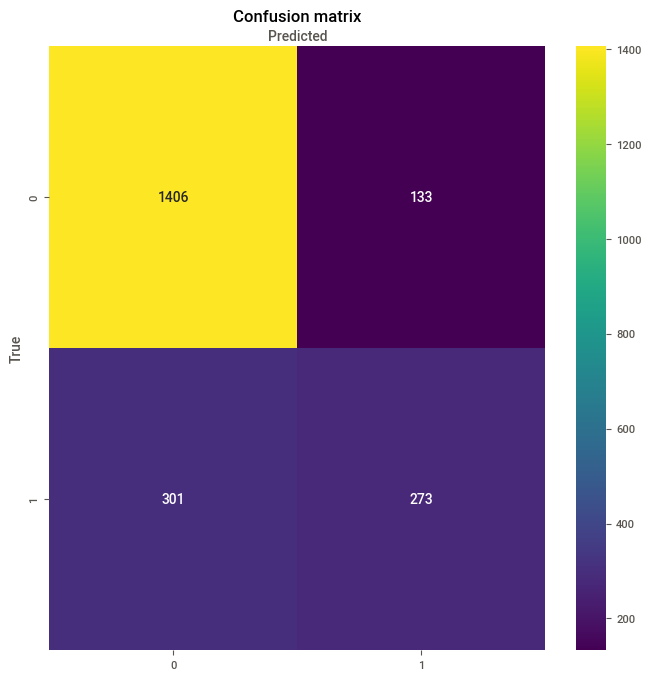

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots(figsize=(8, 8))
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted');

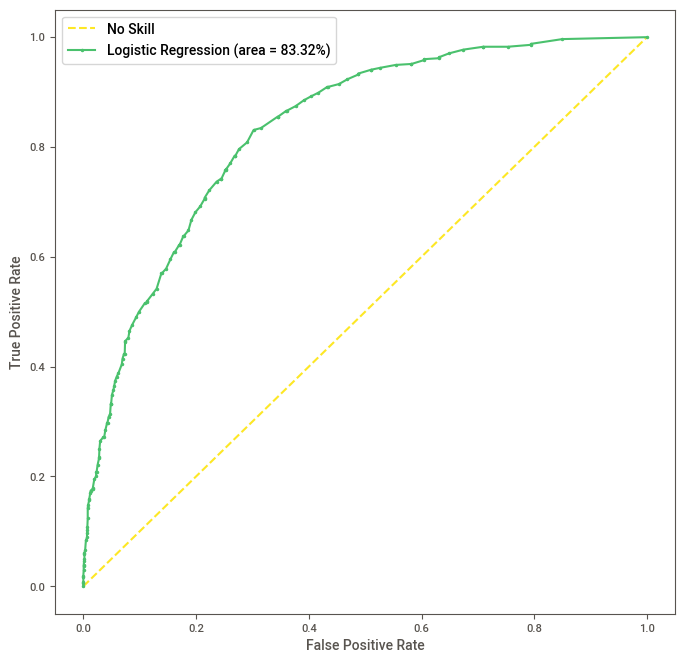

In [ ]:
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax

# Predict test_y values and probabilities based on fitted logistic regression model
yhat = clf.predict_proba(X_test) 

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color='#fde725')
plt.plot(fpr, tpr,  color='#4ac16d', marker='.', label='Logistic Regression (area = {}%)'.format((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])*100).round(2)))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# show the plot
plt.show()